# Modified MNIST Classification
## Group 51

In [1]:
#Importing the required libraries 
import numpy  as np  
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input, Dense, TimeDistributed
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Activation, MaxPool2D, Convolution2D
from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras.models import load_model
from  keras.utils import np_utils
from keras.optimizers import SGD, RMSprop, Adam, Nadam
from __future__ import print_function
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
# Change the directory according to where the datasets are located 
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
# Change the directory according to the location of the dataset
cd gdrive/My\ Drive/AML/Project\ 3

/content/gdrive/My Drive/AML/Project 3


In [4]:
#Loading the data
X_train = pd.read_pickle('./train_images.pkl')
X_test  = pd.read_pickle('./test_images.pkl')
Y_train = pd.read_csv('./train_labels.csv')
Y_train = Y_train['Category']
Y_train = Y_train.values.reshape(-1, 1)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)

(40000, 64, 64)
(10000, 64, 64)
(40000, 1)


In [0]:
# Function for displaying the image to see what the raw image looks like
def display_image(imgs, n_cols=4):
    n_rows = int(np.ceil(len(imgs)/float(n_cols)))
    fn, ax = plt.subplots(n_rows, n_cols)
    fn.subplots_adjust(hspace=0.75)
    for i in range(n_rows):
        for j in range(n_cols):
            row = ax if n_rows == 1 else ax[i]
            if i*4+j < len(imgs):
                row[j].imshow(imgs[i*n_cols+j])    


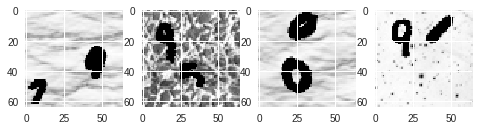

In [6]:
# Displaying some of the raw images
display_image(X_train[:4], n_cols=4)

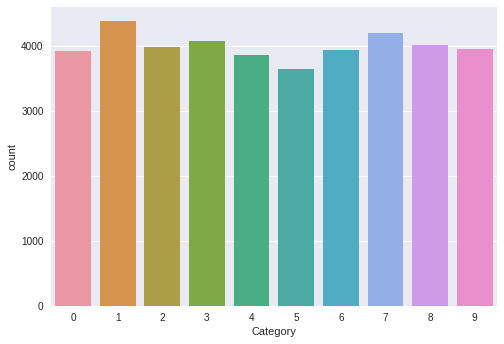

In [7]:
# Plotting the Histogram for the training set labels 
Y_count = pd.read_csv('./train_labels.csv')['Category']
g = sns.countplot(Y_count)

## Image Pre-processing

In [0]:
# Function to convert the image from greyscale to black and white
def threshold_image(img, thresh=254, maxValue=255):
  '''
  This function turns the raw original image into binary(black and white) image using cv2.threshold
  '''
  # turn image to binary values
  ret, thresh = cv2.threshold(img, thresh, maxValue, cv2.THRESH_BINARY)
  
  # convert to unsigned 8 bit to work with findContours()
  thresh = thresh.astype(np.uint8)
  
  return thresh

In [0]:
# Function to get the digits present in one image using the bounding box approach by finding the contours
def get_bounding_box(img,thresh=254,maxValue=255):
  ''' 
  This function returns the subimages from image using bounding box approach (cv2.boundingRect())
  '''  
  # turn image to binary values that is black and white instead of greyscale. 
  dst = threshold_image(img)
  
  # Finding the Contours using cv2.findContours()
  image, contours, hier = cv2.findContours(dst, cv2.RETR_EXTERNAL,
                cv2.CHAIN_APPROX_SIMPLE)
  
  # getting subimages from the contours
  images = []
  for cnt in contours:
    x, y, width, height = cv2.boundingRect(cnt)
    images.append(image[y: y+height, x:x+width])  
    
  return images

In [0]:
# Function to identify the digit that occupies the largest area
def get_largest_area(images):  
  '''
  This function returns the subimage that is the largest in area
  '''  
  count=[]
  for img in images:
    # Finding the larger dimension that is the height or the width for each image
    count.append(max(img.shape))
  # Finding the largest dimension of all the images in the dataset  
  index = count.index(max(count))  
  # Returing the image that has the largest height or the largest width
  return images[index]

In [0]:
# Function that resizes the image with padding
def resize_pad_image(img, size=(20,20), pad = 4):
    '''
    This function resizes the image by interpolation method and we get scaled image by padding
    '''
    height, width = img.shape[:2]
    shrink_height, shrink_width = size
    
    # shrink image using interpolation
    if height > shrink_height or width > shrink_width: 
        interpolate_image = cv2.INTER_AREA
    # stretch image using interpolation
    else: 
        interpolate_image = cv2.INTER_CUBIC

    # aspect ratio of image
    aspect_ratio = width/height  

    # Scaling the image and pad sizing
    # horizontal image if aspect ratio > 1
    if aspect_ratio > 1: 
        width_new = shrink_width
        height_new = np.round(width_new/aspect_ratio).astype(int)
        pad_vertical = (shrink_height-height_new)/2
        pad_top, pad_botttom = np.floor(pad_vertical).astype(int), np.ceil(pad_vertical).astype(int)
        pad_left, pad_right = 0, 0
    # vertical image if aspect ratio < 1
    elif aspect_ratio < 1: 
        height_new = shrink_height
        width_new = np.round(height_new*aspect_ratio).astype(int)
        pad_horizontal = (shrink_width-width_new)/2
        pad_left, pad_right = np.floor(pad_horizontal).astype(int), np.ceil(pad_horizontal).astype(int)
        pad_top, pad_botttom = 0, 0
    # square image
    else: 
        height_new, width_new = shrink_height, shrink_width
        pad_left, pad_right, pad_top, pad_botttom = 0, 0, 0, 0

    # scale and pad
    padColor = 0
    scaled_image = cv2.resize(img, (width_new, height_new), interpolation=interpolate_image)
    scaled_image = cv2.copyMakeBorder(scaled_image, pad_top, pad_botttom, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT, value=padColor)
    scaled_image = cv2.copyMakeBorder(scaled_image, pad, pad, pad, pad, borderType=0)
    return scaled_image

In [0]:
# Function that takes our dataset as the input and outputs the processed dataset using the support functions coded above.
def preprocess_image(data):
  '''
  This is the main preprocess function which calls other functions to get the digit with largest area
  ''' 
  preprocess_data = []
  for image in data:
    # for getting the subimages
    sub_images =  get_bounding_box(image.reshape(64,64))
    # finding the number with largest area
    largest_area = get_largest_area(sub_images)    
    # rescaling it
    rescaled = resize_pad_image(largest_area)
    preprocess_data.append(rescaled)

  return np.asarray(preprocess_data)

In [0]:
# We get processed train and test images
X_train_processed = preprocess_image(X_train)
X_test_processed  = preprocess_image(X_test)

Processed training images...


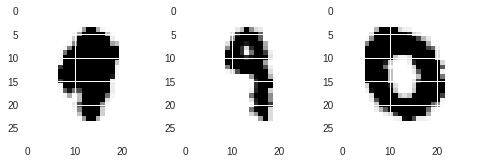

In [14]:
# Displaying the images after processing them to verify what we have done is correct
print("Processed training images...")
display_image(X_train_processed[:3], n_cols=3)


Text(0.5, 1.0, 'Pixel Value Distribution')

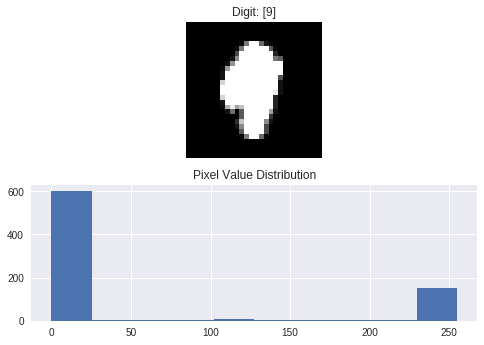

In [15]:
# Distribution of our pixel values.
fig = plt.figure()
plt.subplot(2,1,1)
plt.imshow(X_train_processed[0], cmap='gray', interpolation='none')
plt.title("Digit: {}".format(Y_train[0]))
plt.xticks([])
plt.yticks([])
plt.subplot(2,1,2)
plt.hist(X_train_processed[0].reshape(784))
plt.title("Pixel Value Distribution")

Processed testing images...


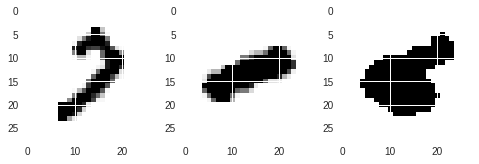

In [16]:
# Displaying some of the preprocessed images to check the results of the preprocessing of the data
print("Processed testing images...")
display_image(X_test_processed[:3], n_cols=3)

Normalizing the image and splitting the dataset into training and validation 

In [0]:
# Second processing of the images

# Normalising the images
X_train_processed_N = X_train_processed/255
X_test_processed_N  = X_test_processed/255

# Reshaping to feed the model
X_train_processed_N = X_train_processed_N.reshape(X_train_processed_N.shape[0], 28, 28, 1).astype('float32')
X_test_processed_N  = X_test_processed_N.reshape(X_test_processed_N.shape[0], 28, 28, 1).astype('float32')

# Training and validation split
x_train, x_test, y_train, y_test = train_test_split( X_train_processed_N, Y_train, test_size=0.1, random_state=None)

# Converting the labels of the training set to the classes they belong to
y_binary = np_utils.to_categorical(y_train)
y_valid_binary= np_utils.to_categorical(y_test)

Defining the callbacks

In [0]:
# Callbacks

# Hyperparameters for our models
# ReduceonPlateau: Stops updating the learning weights for the models when the accuracy does not improve
lr_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                 patience=3, 
                                 verbose=1, 
                                 factor=0.5, 
                                 min_lr=0.00001)

# Learningrateschedular: Updates the learning rate depending on the epoch index and the current weights. 
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

Data Augmentation

In [0]:
# Data Augumentation

datagen = ImageDataGenerator(
    rotation_range=20, 
    width_shift_range=0.08,
    shear_range=0.2,
    height_shift_range=0.08,
    )

datagen.fit(x_train)

In [0]:
# Update the parameter values 

num_classes = 10
n_epochs = 50
batch_size = 128
nb_conv1=3

### CNN Model

In [0]:
#CNN Model that takes the size of the convolution as the input and returns the complete CNN Model 

def CNN_model(nb_conv):
 
  # creating the model
  model = Sequential()
  
  model.add(Conv2D(64, (nb_conv, nb_conv), input_shape=(28, 28, 1), activation='relu'))
  model.add(Conv2D(64, (nb_conv, nb_conv), activation='relu'))
  model.add(MaxPooling2D((2, 2), strides=(2,2)))
  model.add(Dropout(0.25))
  
  model.add(Conv2D(128, (nb_conv, nb_conv), activation='relu'))
  model.add(Conv2D(128, (nb_conv, nb_conv), activation='relu'))
  model.add(MaxPooling2D((2, 2), strides=(2,2)))
  model.add(Dropout(0.25))
  

  model.add(Flatten())
  model.add(Dense(2000, activation='relu'))
  model.add(Dropout(0.25))
  model.add(Dense(2000, activation='relu'))
  model.add(Dropout(0.25))
  model.add(Dense(num_classes, activation='softmax'))
  
  #model.load_weights('best_weights.hdf5')
  # Compiling the model
  model.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=['accuracy']) 
  
  return model

### VGG5 Model

In [0]:
# VGG Model: Takes the size of the convolution as the input and returns the complete model
# reference taken from https://github.com/kkweon/mnist-competition/blob/master/vgg5.py
def Vgg_model(nb_conv):
 
  # creating the model
  model = Sequential()
  
  #1st 2 layer
  model.add(Conv2D(64, (nb_conv, nb_conv), input_shape=(28, 28,1), activation=None, padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  
  model.add(Conv2D(64, (nb_conv, nb_conv), activation=None, padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  
  model.add(MaxPooling2D((2, 2), strides=(2,2)))
  
  #2nd two layer
  model.add(Conv2D(128, (nb_conv, nb_conv), activation=None, padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  
  model.add(Conv2D(128, (nb_conv, nb_conv), activation=None, padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  
  model.add(MaxPooling2D((2, 2), strides=(2,2)))
  
  #1st 3 layer
  model.add(Conv2D(256, (nb_conv, nb_conv), activation=None, padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  
  model.add(Conv2D(256, (nb_conv,nb_conv), activation=None, padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  
  model.add(Conv2D(256, (nb_conv, nb_conv), activation=None, padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  
  model.add(MaxPooling2D((2, 2), strides=(2,2)))
  
  #2nd 3 layer
  model.add(Conv2D(512, (nb_conv, nb_conv), activation=None, padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  
  model.add(Conv2D(512, (nb_conv, nb_conv), activation=None, padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  
  model.add(Conv2D(512, (nb_conv, nb_conv), activation=None, padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  
  model.add(MaxPooling2D((2, 2), strides=(2,2)))
 
  
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dense(512, activation='relu'))
  model.add(Dense(num_classes, activation='softmax'))
  
  #model.load_weights('best_weights.hdf5')
  # Compiling the model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  
  return model

### ResNet Model

In [23]:
# RESNET model
# It was obtained from: https://github.com/raghakot/keras-resnet

from __future__ import division

import six
from keras.models import Model
from keras.layers import (
    Input,
    Activation,
    Dense,
    Flatten
)
from keras.layers.convolutional import (
    Conv2D,
    MaxPooling2D,
    AveragePooling2D
)
from keras.layers.merge import add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K


def _bn_relu(input):
    """Helper to build a BN -> relu block
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)


def _conv_bn_relu(**conv_params):
    """Helper to build a conv -> BN -> relu block
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        conv = Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(input)
        return _bn_relu(conv)

    return f


def _bn_relu_conv(**conv_params):
    """Helper to build a BN -> relu -> conv block.
    This is an improved scheme proposed in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(activation)

    return f


def _shortcut(input, residual):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input)

    return add([shortcut, residual])


def _residual_block(block_function, filters, repetitions, is_first_layer=False):
    """Builds a residual block with repeating bottleneck blocks.
    """
    def f(input):
        for i in range(repetitions):
            init_strides = (1, 1)
            if i == 0 and not is_first_layer:
                init_strides = (2, 2)
            input = block_function(filters=filters, init_strides=init_strides,
                                   is_first_block_of_first_layer=(is_first_layer and i == 0))(input)
        return input

    return f


def basic_block(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv2D(filters=filters, kernel_size=(3, 3),
                           strides=init_strides,
                           padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=l2(1e-4))(input)
        else:
            conv1 = _bn_relu_conv(filters=filters, kernel_size=(3, 3),
                                  strides=init_strides)(input)

        residual = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv1)
        return _shortcut(input, residual)

    return f


def bottleneck(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Bottleneck architecture for > 34 layer resnet.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    Returns:
        A final conv layer of filters * 4
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv_1_1 = Conv2D(filters=filters, kernel_size=(1, 1),
                              strides=init_strides,
                              padding="same",
                              kernel_initializer="he_normal",
                              kernel_regularizer=l2(1e-4))(input)
        else:
            conv_1_1 = _bn_relu_conv(filters=filters, kernel_size=(1, 1),
                                     strides=init_strides)(input)

        conv_3_3 = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv_1_1)
        residual = _bn_relu_conv(filters=filters * 4, kernel_size=(1, 1))(conv_3_3)
        return _shortcut(input, residual)

    return f


def _handle_dim_ordering():
    global ROW_AXIS
    global COL_AXIS
    global CHANNEL_AXIS
    if K.image_dim_ordering() == 'tf':
        ROW_AXIS = 1
        COL_AXIS = 2
        CHANNEL_AXIS = 3
    else:
        CHANNEL_AXIS = 1
        ROW_AXIS = 2
        COL_AXIS = 3


def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier


class ResnetBuilder(object):
    @staticmethod
    def build(input_shape, num_outputs, block_fn, repetitions):
        """Builds a custom ResNet like architecture.
        Args:
            input_shape: The input shape in the form (nb_channels, nb_rows, nb_cols)
            num_outputs: The number of outputs at final softmax layer
            block_fn: The block function to use. This is either `basic_block` or `bottleneck`.
                The original paper used basic_block for layers < 50
            repetitions: Number of repetitions of various block units.
                At each block unit, the number of filters are doubled and the input size is halved
        Returns:
            The keras `Model`.
        """
        _handle_dim_ordering()
        if len(input_shape) != 3:
            raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")

        # Permute dimension order if necessary
        if K.image_dim_ordering() == 'tf':
            input_shape = (input_shape[1], input_shape[2], input_shape[0])

        # Load function from str if needed.
        block_fn = _get_block(block_fn)

        input = Input(shape=input_shape)
        conv1 = _conv_bn_relu(filters=64, kernel_size=(7, 7), strides=(2, 2))(input)
        pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(conv1)

        block = pool1
        filters = 64
        for i, r in enumerate(repetitions):
            block = _residual_block(block_fn, filters=filters, repetitions=r, is_first_layer=(i == 0))(block)
            filters *= 2

        # Last activation
        block = _bn_relu(block)

        # Classifier block
        block_shape = K.int_shape(block)
        pool2 = AveragePooling2D(pool_size=(block_shape[ROW_AXIS], block_shape[COL_AXIS]),
                                 strides=(1, 1))(block)
        flatten1 = Flatten()(pool2)
        dense = Dense(units=num_outputs, kernel_initializer="he_normal",
                      activation="softmax")(flatten1)

        model = Model(inputs=input, outputs=dense)
        return model

    @staticmethod
    def build_resnet_18(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [2, 2, 2, 2])


# input image dimensions
img_rows, img_cols = 28, 28
nb_classes= 10
img_channels = 1

model5 = ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model5.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


### LSTM Model

In [0]:
#LSTM Model

# Embedding dimensions.
row_hidden = 128
col_hidden = 128

# 4D input.
x = Input(shape=(28, 28, 1))

# Encodes a row of pixels using TimeDistributed Wrapper.
encoded_rows = TimeDistributed(LSTM(row_hidden))(x)

# Encodes columns of encoded rows.
encoded_columns = LSTM(col_hidden)(encoded_rows)

# Final predictions and model.
prediction = Dense(num_classes, activation='softmax')(encoded_columns)
model6 = Model(x, prediction)
model6.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

In [25]:
# CNN with GridSearch CV

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

def make_model(dropout_rate, dense_layer_sizes, filters):

  model = Sequential()
  
  model.add(Conv2D(filters, (3,3), input_shape=(28, 28, 1), activation='relu'))
  model.add(Conv2D(filters, (3,3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(2,2)))
  model.add(Dropout(dropout_rate))
  
  model.add(Conv2D(filters, (3,3), activation='relu'))
  model.add(Conv2D(filters, (3,3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(2,2)))
  model.add(Dropout(dropout_rate))

  model.add(Flatten())
  for layer_size in dense_layer_sizes:
        model.add(Dense(layer_size))
        model.add(Activation('relu'))
  model.add(Dropout(dropout_rate))
  for layer_size in dense_layer_sizes:
        model.add(Dense(layer_size))
        model.add(Activation('relu'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(10, activation='softmax'))
  model.compile(loss='categorical_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
  return model


dense_size_candidates = [[512], [2000]]
my_classifier = KerasClassifier(make_model, batch_size=64)
validator = GridSearchCV(my_classifier,
                         param_grid={'dense_layer_sizes': dense_size_candidates,
                                     'dropout_rate' :[0.25, 0.4, 0.5],
                                     'epochs': [10],
                                     'filters': [64, 128],},
                         scoring='neg_log_loss',
                         n_jobs=1)
grid_result = validator.fit(x_train, y_binary)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means  = grid_result.cv_results_['mean_test_score']
stds   = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
24000/24000 [==============================] - 14s 581us/step - loss: 0.7172 - acc: 0.7837
Epoch 2/10
24000/24000 [==============================] - 9s 359us/step - loss: 0.3454 - acc: 0.9102
Epoch 3/10
24000/24000 [==============================] - 9s 357us/step - loss: 0.2926 - acc: 0.9276
Epoch 4/10
24000/24000 [==============================] - 9s 356us/step - loss: 0.2605 - acc: 0.9348
Epoch 5/10
24000/24000 [==============================] - 9s 357us/step - loss: 0.2378 - acc: 0.9415
Epoch 6/10
24000/24000 [==============================] - 9s 359us/step - loss: 0.2186 - acc: 0.9463
Epoch 7/10
24000/24000 [==============================] - 9s 357us/step - loss: 0.2001 - acc: 0.9499
Epoch 8/10
24000/24000 [==============================] - 9s 357us/step - loss: 0.1908 - acc: 0.9530
Epoch 9/10
24000/24000 [====

From here we run the above models and measure the performance of the models using the accuracy.

In [26]:
#Model 1
# CNN Model with ReduceLROnPlateau and Model checkpoint
#Define a model checkpoint
model_checkpoint = ModelCheckpoint('best_weights1.hdf5', verbose=1, save_best_only=True)
model1 = CNN_model(nb_conv1)

history1 = model1.fit_generator(datagen.flow(x_train, y_binary, batch_size=batch_size),
                              steps_per_epoch=x_train.shape[0] // batch_size,
                              validation_data=(x_test, y_valid_binary),
                              epochs = n_epochs, callbacks=[lr_reduction, model_checkpoint] )
                   

Epoch 1/50
281/281 [==============================] - 26s 93ms/step - loss: 0.7233 - acc: 0.7797 - val_loss: 0.2818 - val_acc: 0.9300

Epoch 00001: val_loss improved from inf to 0.28184, saving model to best_weights1.hdf5
Epoch 2/50
281/281 [==============================] - 17s 60ms/step - loss: 0.3580 - acc: 0.9074 - val_loss: 0.2624 - val_acc: 0.9415

Epoch 00002: val_loss improved from 0.28184 to 0.26241, saving model to best_weights1.hdf5
Epoch 3/50
281/281 [==============================] - 17s 60ms/step - loss: 0.3121 - acc: 0.9210 - val_loss: 0.2456 - val_acc: 0.9427

Epoch 00003: val_loss improved from 0.26241 to 0.24562, saving model to best_weights1.hdf5
Epoch 4/50
281/281 [==============================] - 17s 60ms/step - loss: 0.2890 - acc: 0.9293 - val_loss: 0.2704 - val_acc: 0.9417

Epoch 00004: val_loss did not improve from 0.24562
Epoch 5/50
281/281 [==============================] - 16s 59ms/step - loss: 0.2729 - acc: 0.9330 - val_loss: 0.2509 - val_acc: 0.9465

Epoch

In [0]:
# Model 2
# CNN Model with LearningRateScheduler and Model checkpoint
nb_conv2=3
model2 = CNN_model(nb_conv2)
model_checkpoint2 = ModelCheckpoint('best_weights2.hdf5', verbose=1, save_best_only=True)
history2 = model2.fit_generator(datagen.flow(x_train, y_binary, batch_size=batch_size),
                              steps_per_epoch=x_train.shape[0] // batch_size,
                              validation_data=(x_test, y_valid_binary),
                              epochs = n_epochs, callbacks=[annealer, model_checkpoint2] )

In [0]:
#Model 3
#Vgg model with ReduceOnPlateau and Model checkpoint
nb_conv3=3
model3 = Vgg_model(nb_conv3)
model_checkpoint3 = ModelCheckpoint('best_weights3.hdf5', verbose=1, save_best_only=True)
history3 = model3.fit_generator(datagen.flow(x_train, y_binary, batch_size=batch_size),
                              steps_per_epoch=x_train.shape[0] // batch_size,
                              validation_data=(x_test, y_valid_binary),
                              epochs = n_epochs, callbacks=[lr_reduction, model_checkpoint3] )

Epoch 1/50
281/281 [==============================] - 48s 171ms/step - loss: 0.6758 - acc: 0.7948 - val_loss: 0.8962 - val_acc: 0.7890

Epoch 00001: val_loss improved from inf to 0.89621, saving model to best_weights3.hdf5
Epoch 2/50
281/281 [==============================] - 37s 132ms/step - loss: 0.3234 - acc: 0.9169 - val_loss: 0.4791 - val_acc: 0.8760

Epoch 00002: val_loss improved from 0.89621 to 0.47909, saving model to best_weights3.hdf5
Epoch 3/50
281/281 [==============================] - 37s 132ms/step - loss: 0.2840 - acc: 0.9283 - val_loss: 0.3212 - val_acc: 0.9263

Epoch 00003: val_loss improved from 0.47909 to 0.32116, saving model to best_weights3.hdf5
Epoch 4/50
281/281 [==============================] - 37s 132ms/step - loss: 0.2618 - acc: 0.9363 - val_loss: 0.3255 - val_acc: 0.9160

Epoch 00004: val_loss did not improve from 0.32116
Epoch 5/50
281/281 [==============================] - 41s 145ms/step - loss: 0.2474 - acc: 0.9402 - val_loss: 0.3077 - val_acc: 0.9195



In [0]:
#Model 4
#Vgg model with LearningRateScheduler and Model checkpoint
nb_conv4=4
model4 = Vgg_model(nb_conv4)
model_checkpoint4 = ModelCheckpoint('best_weights4.hdf5', verbose=1, save_best_only=True)
history4 = model4.fit_generator(datagen.flow(x_train, y_binary, batch_size=batch_size),
                              steps_per_epoch=x_train.shape[0] // batch_size,
                              validation_data=(x_test, y_valid_binary),
                              epochs = n_epochs, callbacks=[annealer, model_checkpoint4] )

Epoch 1/50
281/281 [==============================] - 72s 255ms/step - loss: 1.0174 - acc: 0.6539 - val_loss: 1.0111 - val_acc: 0.7458

Epoch 00001: val_loss improved from inf to 1.01112, saving model to best_weights4.hdf5
Epoch 2/50
281/281 [==============================] - 66s 236ms/step - loss: 0.3565 - acc: 0.9073 - val_loss: 0.3928 - val_acc: 0.9125

Epoch 00002: val_loss improved from 1.01112 to 0.39279, saving model to best_weights4.hdf5
Epoch 3/50
281/281 [==============================] - 66s 234ms/step - loss: 0.2981 - acc: 0.9242 - val_loss: 0.6242 - val_acc: 0.8482

Epoch 00003: val_loss did not improve from 0.39279
Epoch 4/50
281/281 [==============================] - 66s 234ms/step - loss: 0.2684 - acc: 0.9332 - val_loss: 0.2768 - val_acc: 0.9350

Epoch 00004: val_loss improved from 0.39279 to 0.27680, saving model to best_weights4.hdf5
Epoch 5/50
281/281 [==============================] - 66s 234ms/step - loss: 0.2558 - acc: 0.9378 - val_loss: 0.3293 - val_acc: 0.9173



In [0]:
#Model 5
#Resnet model
model_checkpoint5 = ModelCheckpoint('best_weights5.hdf5', verbose=1, save_best_only=True)
history5 = model5.fit_generator(datagen.flow(x_train, y_binary, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    validation_data=(x_test, y_valid_binary),
                    epochs=n_epochs, verbose=1, max_q_size=100,
                    callbacks=[lr_reduction, model_checkpoint5])

Epoch 1/50
281/281 [==============================] - 53s 188ms/step - loss: 1.1180 - acc: 0.8498 - val_loss: 0.9418 - val_acc: 0.8865

Epoch 00001: val_loss improved from inf to 0.94177, saving model to best_weights5.hdf5
Epoch 2/50
281/281 [==============================] - 36s 128ms/step - loss: 0.8068 - acc: 0.9077 - val_loss: 0.9291 - val_acc: 0.8470

Epoch 00002: val_loss improved from 0.94177 to 0.92911, saving model to best_weights5.hdf5
Epoch 3/50
281/281 [==============================] - 36s 127ms/step - loss: 0.6895 - acc: 0.9189 - val_loss: 0.6492 - val_acc: 0.9187

Epoch 00003: val_loss improved from 0.92911 to 0.64922, saving model to best_weights5.hdf5
Epoch 4/50
281/281 [==============================] - 36s 128ms/step - loss: 0.6124 - acc: 0.9227 - val_loss: 0.5894 - val_acc: 0.9213

Epoch 00004: val_loss improved from 0.64922 to 0.58945, saving model to best_weights5.hdf5
Epoch 5/50
281/281 [==============================] - 36s 127ms/step - loss: 0.5583 - acc: 0.927

In [41]:
#Model 6
# LSTM
history6 = model6.fit_generator(datagen.flow(x_train, y_binary, batch_size=batch_size),
                              steps_per_epoch=x_train.shape[0] // batch_size,
                              validation_data=(x_test, y_valid_binary),
                              epochs = n_epochs, callbacks=[lr_reduction] )

Epoch 1/50
281/281 [==============================] - 74s 264ms/step - loss: 1.6925 - acc: 0.4097 - val_loss: 1.0645 - val_acc: 0.6585
Epoch 2/50
281/281 [==============================] - 60s 214ms/step - loss: 0.9533 - acc: 0.6994 - val_loss: 0.7233 - val_acc: 0.7762
Epoch 3/50
281/281 [==============================] - 60s 215ms/step - loss: 0.6538 - acc: 0.8020 - val_loss: 0.4931 - val_acc: 0.8580
Epoch 4/50
281/281 [==============================] - 61s 215ms/step - loss: 0.5047 - acc: 0.8536 - val_loss: 0.4349 - val_acc: 0.8742
Epoch 5/50
281/281 [==============================] - 60s 215ms/step - loss: 0.4297 - acc: 0.8780 - val_loss: 0.3879 - val_acc: 0.8928
Epoch 6/50
281/281 [==============================] - 60s 212ms/step - loss: 0.3932 - acc: 0.8909 - val_loss: 0.3445 - val_acc: 0.9085
Epoch 7/50
281/281 [==============================] - 60s 214ms/step - loss: 0.3603 - acc: 0.9027 - val_loss: 0.3492 - val_acc: 0.9048
Epoch 8/50
281/281 [==============================] - 6

### Evaluation of all the models

In [27]:
# Evaluating CNN with ReducedLROnPlateau Callback
model1 = load_model('best_weights1.hdf5')
Accuracy = model1.evaluate(x_test, y_valid_binary, verbose=0)
print("Validation Accuracy for model 1: %.2f%%" % (Accuracy[1]*100))

Validation Accuracy for model 1: 96.23%


In [28]:
# Evaluating CNN with LearningRateScheduler Callback
model2 = load_model('best_weights2.hdf5')
Accuracy = model2.evaluate(x_test, y_valid_binary, verbose=0)
print("Validation Accuracy for model 2: %.2f%%" % (Accuracy[1]*100))

Validation Accuracy for model 2: 96.38%


In [29]:
# Evaluating VGG with ReducedLROnPlateau Callback
model3 = load_model('best_weights3.hdf5')
Accuracy = model3.evaluate(x_test, y_valid_binary, verbose=0)
print("Validation Accuracy for model 3: %.2f%%" % (Accuracy[1]*100))

Validation Accuracy for model 3: 97.52%


In [69]:
# Evaluating CNN with LearningRateScheduler Callback
model4 = load_model('best_weights4.hdf5')
Accuracy = model4.evaluate(x_test, y_valid_binary, verbose=0)
print("Validation Accuracy for model 4: %.2f%%" % (Accuracy[1]*100))

Validation Accuracy for model 4: 97.78%


In [31]:
# Evaluating ResNet with ReducedLROnPlateau Callback
model5 = load_model('best_weights5.hdf5')
Accuracy = model5.evaluate(x_test, y_valid_binary, verbose=0)
print("Validation Accuracy for model 5: %.2f%%" % (Accuracy[1]*100))

Validation Accuracy for model 5: 97.60%


In [68]:
# Evaluating LSTM with ReducedLROnPlateau Callback
Accuracy = model6.evaluate(x_test, y_valid_binary, verbose=0)
print("Validation Accuracy for model 6: %.2f%%" % (Accuracy[1]*100))

Validation Accuracy for model 6: 95.08%


### Plotting the model accuracy and model loss for training data vs. validation dataset

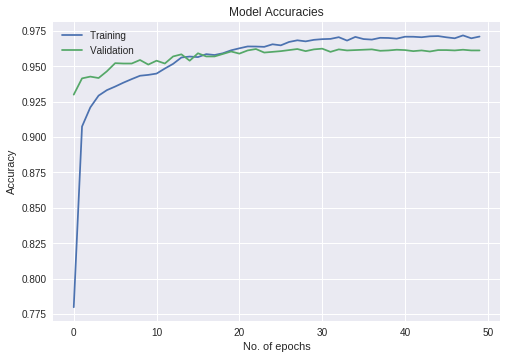

In [38]:
#Plotting the 'Accuracies vs Epochs' for Training and validation set
plt.title('Model Accuracies')
plt.plot(history1.history['acc'], label='Training ')
plt.plot(history1.history['val_acc'], label='Validation ')
plt.xlabel('No. of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


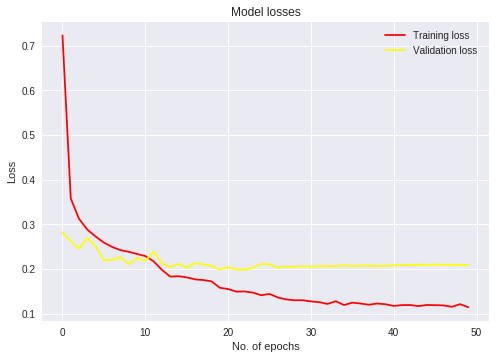

In [39]:
#Plotting the 'Losses vs Epochs' for Training and validation set
plt.title('Model losses')
plt.plot(history1.history['loss'],'red', label='Training loss ')
plt.plot(history1.history['val_loss'],'yellow', label='Validation loss ')
plt.xlabel('No. of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Ensembling all the models

In [0]:
# Predicting the y valid and checking the accuracy by ensembling all the above models that is using the maximum of the results
results = np.zeros( (x_test.shape[0],10) )
results = results + model1.predict(x_test)
results = results + model2.predict(x_test)
results = results + model3.predict(x_test)
results = results + model4.predict(x_test)
results = results + model5.predict(x_test)
results = results + model6.predict(x_test)
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")

### Evaluating our results with confusion matrix

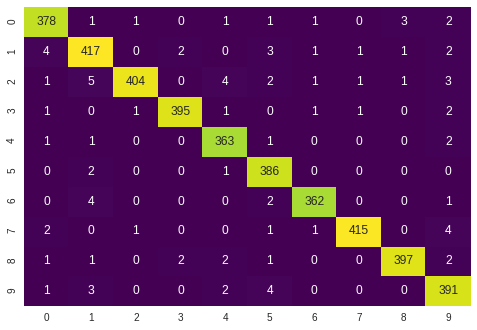

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       388
           1       0.96      0.97      0.96       431
           2       0.99      0.96      0.97       422
           3       0.99      0.98      0.99       402
           4       0.97      0.99      0.98       368
           5       0.96      0.99      0.98       389
           6       0.99      0.98      0.98       369
           7       0.99      0.98      0.99       424
           8       0.99      0.98      0.98       406
           9       0.96      0.98      0.97       401

   micro avg       0.98      0.98      0.98      4000
   macro avg       0.98      0.98      0.98      4000
weighted avg       0.98      0.98      0.98      4000

Accuracy score: 97.70%


In [42]:
# Confusion matrix, Accuracy score for the validation set
conf_mat = confusion_matrix(results , y_test) 
sns.heatmap(conf_mat, annot=True,annot_kws={"size": 12},fmt='g', cbar=False, cmap="viridis")
plt.show()
print(classification_report(results,y_test))  
Accuracy = accuracy_score(results, y_test)
print ("Accuracy score: {0:.2f}%".format(Accuracy*100))

### Fitting our model to the Test Set

In [0]:
#Prediction of labels for the test set
results_test = np.zeros( (X_test_processed_N.shape[0],10) )
results_test = results_test + model1.predict(X_test_processed_N)
results_test = results_test + model2.predict(X_test_processed_N)
results_test = results_test + model3.predict(X_test_processed_N)
results_test = results_test + model4.predict(X_test_processed_N)
results_test = results_test + model5.predict(X_test_processed_N)
results_test = results_test + model6.predict(X_test_processed_N)
results_test = np.argmax(results_test,axis = 1)
results_test = pd.Series(results_test)

In [0]:
# Saving the predicted values to csv
my_submission = pd.DataFrame({'Id': np.arange(len(results_test)),
                              'Category': results_test})
my_submission.to_csv('submission_en4.csv',columns = ['Id', 'Category'], index=False)

In [0]:
# Using 10-fold CNN for cross validation
# https://www.kaggle.com/franklemuchahary/basic-cnn-keras-with-cross-validation 

n_fold = 5 #run with 10 for better results
model_cv = [0]*n_fold
nb_conv = 3

for j in range(n_fold):
 
  # creating the model
  model_cv[j] = Sequential()
  
  model_cv[j].add(Conv2D(64, (nb_conv, nb_conv), input_shape=(28, 28,1), activation='relu'))
  model_cv[j].add(Conv2D(64, (nb_conv, nb_conv), activation='relu'))
  model_cv[j].add(MaxPooling2D((2, 2), strides=(2,2)))
  model_cv[j].add(Dropout(0.25))
  
  model_cv[j].add(Conv2D(128, (nb_conv, nb_conv), activation='relu'))
  model_cv[j].add(Conv2D(128, (nb_conv, nb_conv), activation='relu'))
  model_cv[j].add(MaxPooling2D((2, 2), strides=(2,2)))
  model_cv[j].add(Dropout(0.25))
  

  model_cv[j].add(Flatten())
  model_cv[j].add(Dense(2000, activation='relu'))
  model_cv[j].add(Dropout(0.25))
  model_cv[j].add(Dense(2000, activation='relu'))
  model_cv[j].add(Dropout(0.25))
  model_cv[j].add(Dense(num_classes, activation='softmax'))
  
  # Compiling the model
  model_cv[j].compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  
datagen1 = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.08,
        shear_range=0.2,
        height_shift_range=0.08,)  

datagen1.fit(x_train)


In [72]:
history_cv = [0] * n_fold
epochs = 10

y1_binary = np_utils.to_categorical(Y_train)

# Fit the model
for j in range(n_fold):
  
    from sklearn.model_selection import train_test_split
    train_x, test_x, train_y, test_y = train_test_split(X_train_processed_N, y1_binary, random_state = np.random.randint(1,1000, 1)[0], 
                                                   test_size=0.1)
    
    history_cv[j] = model_cv[j].fit_generator(datagen1.flow(train_x, train_y, batch_size=64),
                              epochs = epochs, validation_data = (test_x,test_y),
                              verbose = 0, steps_per_epoch=(len(train_x)//64),validation_steps=(len(test_x)//64),
                              callbacks=[annealer])
    
    print("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        j+1,epochs,max(history_cv[j].history['acc']),max(history_cv[j].history['val_acc']) ))

CNN 1: Epochs=10, Train accuracy=0.94490, Validation accuracy=0.94825
CNN 2: Epochs=10, Train accuracy=0.94521, Validation accuracy=0.95350
CNN 3: Epochs=10, Train accuracy=0.94582, Validation accuracy=0.95550
CNN 4: Epochs=10, Train accuracy=0.94563, Validation accuracy=0.95675
CNN 5: Epochs=10, Train accuracy=0.94404, Validation accuracy=0.95825


In [0]:
# Predicting the accuracy
results_cv = np.zeros( (x_test.shape[0],10) )
for j in range(n_fold):
    results_cv = results_cv + model_cv[j].predict(x_test)
results_cv = np.argmax(results,axis = 1)
results_cv = pd.Series(results,name="Label")
print(confusion_matrix(results_cv , y_test))  
print(classification_report(results_cv,y_test))  
Accuracy = accuracy_score(results_cv, y_test)
print ("Accuracy score: {0:.2f}%".format(Accuracy*100))

In [46]:
# Comparison of optimisers
# Change the optimiser in function CNN_model
# Different optimisers used for comparison are adam, nadam, rmsprop, sgd with momentum and sgd with momentum and nestrov,adamax
# Change adam() for adam in model.compile in CNN_model
model_adam = CNN_model(nb_conv1)

history_adam = model_adam.fit_generator(datagen.flow(x_train, y_binary, batch_size=batch_size),
                              steps_per_epoch=x_train.shape[0] // batch_size,
                              validation_data=(x_test, y_valid_binary),
                              epochs =10, callbacks=[lr_reduction] )


Epoch 1/10
281/281 [==============================] - 32s 114ms/step - loss: 0.7361 - acc: 0.7722 - val_loss: 0.3288 - val_acc: 0.9185
Epoch 2/10
281/281 [==============================] - 17s 60ms/step - loss: 0.3629 - acc: 0.9070 - val_loss: 0.2720 - val_acc: 0.9447
Epoch 3/10
281/281 [==============================] - 17s 61ms/step - loss: 0.3130 - acc: 0.9214 - val_loss: 0.2481 - val_acc: 0.9433
Epoch 4/10
281/281 [==============================] - 17s 60ms/step - loss: 0.2940 - acc: 0.9263 - val_loss: 0.2426 - val_acc: 0.9440
Epoch 5/10
281/281 [==============================] - 17s 60ms/step - loss: 0.2768 - acc: 0.9334 - val_loss: 0.2420 - val_acc: 0.9485
Epoch 6/10
281/281 [==============================] - 17s 60ms/step - loss: 0.2636 - acc: 0.9370 - val_loss: 0.2251 - val_acc: 0.9520
Epoch 7/10
281/281 [==============================] - 17s 60ms/step - loss: 0.2535 - acc: 0.9381 - val_loss: 0.2232 - val_acc: 0.9513
Epoch 8/10
281/281 [==============================] - 17s 60m

In [47]:
#Change Nadam() for Nadam in model.compile in CNN_model
model_nadam = CNN_model(nb_conv1)

history_nadam = model_nadam.fit_generator(datagen.flow(x_train, y_binary, batch_size=batch_size),
                              steps_per_epoch=x_train.shape[0] // batch_size,
                              validation_data=(x_test, y_valid_binary),
                              epochs = 10, callbacks=[lr_reduction] )

Epoch 1/10
281/281 [==============================] - 33s 118ms/step - loss: 0.7531 - acc: 0.7658 - val_loss: 0.2918 - val_acc: 0.9305
Epoch 2/10
281/281 [==============================] - 17s 60ms/step - loss: 0.3588 - acc: 0.9050 - val_loss: 0.2671 - val_acc: 0.9405
Epoch 3/10
281/281 [==============================] - 17s 61ms/step - loss: 0.3116 - acc: 0.9210 - val_loss: 0.2665 - val_acc: 0.9407
Epoch 4/10
281/281 [==============================] - 17s 61ms/step - loss: 0.2887 - acc: 0.9284 - val_loss: 0.2466 - val_acc: 0.9435
Epoch 5/10
281/281 [==============================] - 17s 60ms/step - loss: 0.2755 - acc: 0.9332 - val_loss: 0.2424 - val_acc: 0.9450
Epoch 6/10
281/281 [==============================] - 17s 61ms/step - loss: 0.2588 - acc: 0.9368 - val_loss: 0.2353 - val_acc: 0.9507
Epoch 7/10
281/281 [==============================] - 17s 61ms/step - loss: 0.2538 - acc: 0.9374 - val_loss: 0.2184 - val_acc: 0.9543
Epoch 8/10
281/281 [==============================] - 17s 61m

In [48]:
#Change 'rmsprop' for rmsprop in model.compile in CNN_model
model_rmsprop = CNN_model(nb_conv1)

history_rmsprop = model_rmsprop.fit_generator(datagen.flow(x_train, y_binary, batch_size=batch_size),
                              steps_per_epoch=x_train.shape[0] // batch_size,
                              validation_data=(x_test, y_valid_binary),
                              epochs = 10, callbacks=[lr_reduction] )


Epoch 1/10
281/281 [==============================] - 33s 119ms/step - loss: 0.7620 - acc: 0.7658 - val_loss: 0.2942 - val_acc: 0.9267
Epoch 2/10
281/281 [==============================] - 17s 60ms/step - loss: 0.3523 - acc: 0.9078 - val_loss: 0.2556 - val_acc: 0.9425
Epoch 3/10
281/281 [==============================] - 17s 61ms/step - loss: 0.3054 - acc: 0.9232 - val_loss: 0.2488 - val_acc: 0.9457
Epoch 4/10
281/281 [==============================] - 17s 61ms/step - loss: 0.2856 - acc: 0.9293 - val_loss: 0.2382 - val_acc: 0.9455
Epoch 5/10
281/281 [==============================] - 17s 61ms/step - loss: 0.2699 - acc: 0.9335 - val_loss: 0.2256 - val_acc: 0.9465
Epoch 6/10
281/281 [==============================] - 17s 60ms/step - loss: 0.2591 - acc: 0.9366 - val_loss: 0.2266 - val_acc: 0.9507
Epoch 7/10
281/281 [==============================] - 17s 61ms/step - loss: 0.2508 - acc: 0.9391 - val_loss: 0.2185 - val_acc: 0.9505
Epoch 8/10
281/281 [==============================] - 17s 60m

In [49]:
#  change sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=False) for optimiser in CNN Model
model_sgdmom = CNN_model(nb_conv1)

history_sgdmom = model_sgdmom.fit_generator(datagen.flow(x_train, y_binary, batch_size=batch_size),
                              steps_per_epoch=x_train.shape[0] // batch_size,
                              validation_data=(x_test, y_valid_binary),
                              epochs = 10, callbacks=[lr_reduction] )


Epoch 1/10
281/281 [==============================] - 33s 119ms/step - loss: 0.7550 - acc: 0.7673 - val_loss: 0.3124 - val_acc: 0.9233
Epoch 2/10
281/281 [==============================] - 17s 60ms/step - loss: 0.3586 - acc: 0.9055 - val_loss: 0.2627 - val_acc: 0.9427
Epoch 3/10
281/281 [==============================] - 17s 61ms/step - loss: 0.3108 - acc: 0.9215 - val_loss: 0.2443 - val_acc: 0.9455
Epoch 4/10
281/281 [==============================] - 17s 61ms/step - loss: 0.2909 - acc: 0.9276 - val_loss: 0.2360 - val_acc: 0.9513
Epoch 5/10
281/281 [==============================] - 17s 60ms/step - loss: 0.2747 - acc: 0.9323 - val_loss: 0.2456 - val_acc: 0.9480
Epoch 6/10
281/281 [==============================] - 17s 61ms/step - loss: 0.2622 - acc: 0.9351 - val_loss: 0.2335 - val_acc: 0.9505
Epoch 7/10
281/281 [==============================] - 17s 61ms/step - loss: 0.2484 - acc: 0.9396 - val_loss: 0.2206 - val_acc: 0.9505

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0

In [50]:
# change sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True) for optimiser in CNN Model
model_sgdmomnes = CNN_model(nb_conv1)

history_sgdmomnes = model_sgdmomnes.fit_generator(datagen.flow(x_train, y_binary, batch_size=batch_size),
                              steps_per_epoch=x_train.shape[0] // batch_size,
                              validation_data=(x_test, y_valid_binary),
                              epochs = 10, callbacks=[lr_reduction] )

Epoch 1/10
281/281 [==============================] - 34s 120ms/step - loss: 0.7289 - acc: 0.7744 - val_loss: 0.3259 - val_acc: 0.9253
Epoch 2/10
281/281 [==============================] - 17s 60ms/step - loss: 0.3566 - acc: 0.9064 - val_loss: 0.2503 - val_acc: 0.9455
Epoch 3/10
281/281 [==============================] - 17s 61ms/step - loss: 0.3106 - acc: 0.9212 - val_loss: 0.2443 - val_acc: 0.9447
Epoch 4/10
281/281 [==============================] - 17s 61ms/step - loss: 0.2873 - acc: 0.9287 - val_loss: 0.2492 - val_acc: 0.9440
Epoch 5/10
281/281 [==============================] - 17s 61ms/step - loss: 0.2706 - acc: 0.9337 - val_loss: 0.2429 - val_acc: 0.9450

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/10
281/281 [==============================] - 17s 61ms/step - loss: 0.2324 - acc: 0.9430 - val_loss: 0.2222 - val_acc: 0.9507
Epoch 7/10
281/281 [==============================] - 17s 61ms/step - loss: 0.2226 - acc: 0.9471 - val_loss: 0.208

In [51]:
# change 'adamax' for AdaMax optimiser in CNN Model
model_adamax = CNN_model(nb_conv1)

history_adamax = model_adamax.fit_generator(datagen.flow(x_train, y_binary, batch_size=batch_size),
                              steps_per_epoch=x_train.shape[0] // batch_size,
                              validation_data=(x_test, y_valid_binary),
                              epochs = 10, callbacks=[lr_reduction] )

Epoch 1/10
281/281 [==============================] - 34s 122ms/step - loss: 0.7402 - acc: 0.7723 - val_loss: 0.3106 - val_acc: 0.9265
Epoch 2/10
281/281 [==============================] - 17s 60ms/step - loss: 0.3542 - acc: 0.9069 - val_loss: 0.2706 - val_acc: 0.9393
Epoch 3/10
281/281 [==============================] - 17s 61ms/step - loss: 0.3099 - acc: 0.9213 - val_loss: 0.2447 - val_acc: 0.9435
Epoch 4/10
281/281 [==============================] - 17s 61ms/step - loss: 0.2907 - acc: 0.9262 - val_loss: 0.2412 - val_acc: 0.9463
Epoch 5/10
281/281 [==============================] - 17s 61ms/step - loss: 0.2720 - acc: 0.9337 - val_loss: 0.2347 - val_acc: 0.9453
Epoch 6/10
281/281 [==============================] - 17s 61ms/step - loss: 0.2621 - acc: 0.9352 - val_loss: 0.2383 - val_acc: 0.9507
Epoch 7/10
281/281 [==============================] - 17s 61ms/step - loss: 0.2510 - acc: 0.9393 - val_loss: 0.2218 - val_acc: 0.9540
Epoch 8/10
281/281 [==============================] - 17s 60m

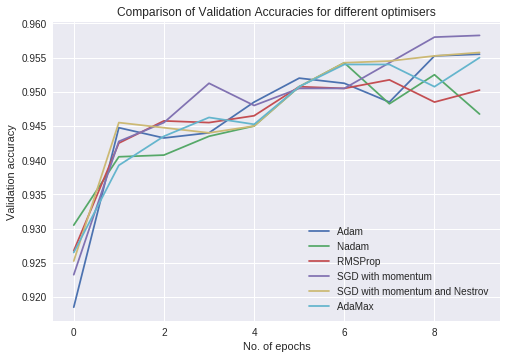

In [52]:
# Comparison of Validation Accuracies for different optimisers
plt.title('Comparison of Validation Accuracies for different optimisers')
plt.plot(history_adam.history['val_acc'], label='Adam ')
plt.plot(history_nadam.history['val_acc'], label='Nadam ')
plt.plot(history_rmsprop.history['val_acc'], label='RMSProp ')
plt.plot(history_sgdmom.history['val_acc'], label='SGD with momentum')
plt.plot(history_sgdmomnes.history['val_acc'], label='SGD with momentum and Nestrov ')
plt.plot(history_adamax.history['val_acc'], label='AdaMax ')

plt.ylabel('Validation accuracy')  
plt.xlabel('No. of epochs')
plt.legend()
plt.show()

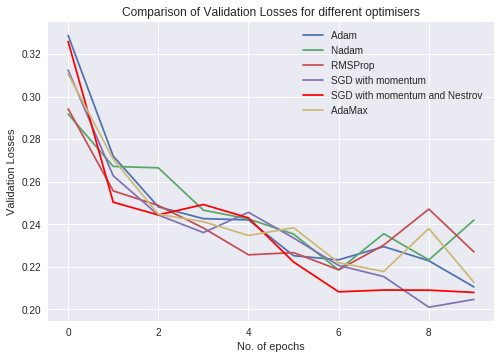

In [53]:
# Comparison of Validation loss for different optimisers
plt.title('Comparison of Validation Losses for different optimisers')
plt.plot(history_adam.history['val_loss'], label='Adam ')
plt.plot(history_nadam.history['val_loss'], label='Nadam ')
plt.plot(history_rmsprop.history['val_loss'], label='RMSProp ')
plt.plot(history_sgdmom.history['val_loss'], label='SGD with momentum')
plt.plot(history_sgdmomnes.history['val_loss'],'red', label='SGD with momentum and Nestrov ')
plt.plot(history_adamax.history['val_loss'], label='AdaMax ')

plt.ylabel('Validation Losses')  
plt.xlabel('No. of epochs')
plt.legend()
plt.show()